# Per-Metro Model v3: Training and Evaluation

## Objective
Train per-metro models to predict home prices. If the model accurately predicts prices for 2025 test examples, we have confidence in its future predictions.

## Approach
- Load prepared data from notebook 03
- Train separate models for each metro
- Evaluate on test set (especially 2025 examples)
- Save models for app integration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
from pathlib import Path
from datetime import datetime

# ML imports
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import joblib

try:
    from xgboost import XGBRegressor
    HAS_XGBOOST = True
except ImportError:
    print("XGBoost not installed. Run: pip install xgboost")
    HAS_XGBOOST = False

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

print("Libraries loaded successfully")
print(f"XGBoost available: {HAS_XGBOOST}")

Libraries loaded successfully
XGBoost available: True


## 1. Load Prepared Data

In [2]:
# Load data from notebook 03
with open('../data/processed/ml_data_v3.pkl', 'rb') as f:
    data = pickle.load(f)

train_df = data['train_df']
test_df = data['test_df']
feature_cols = data['feature_cols']
target_col = data['target_col']

print(f"Train set: {len(train_df):,} examples")
print(f"Test set: {len(test_df):,} examples")
print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")

Train set: 40,024 examples
Test set: 10,007 examples
Features: 16
Target: target_price


In [3]:
# Check data by metro
print("Train set by metro:")
print(train_df['metro'].value_counts())

print("\nTest set by metro:")
print(test_df['metro'].value_counts())

Train set by metro:
metro
dallas             8963
fort_worth         8654
san_antonio        5214
fort_lauderdale    4007
houston            3691
jacksonville       2946
tampa              2154
orlando            2118
austin             1077
miami               678
waco                262
abilene             260
Name: count, dtype: int64

Test set by metro:
metro
dallas             2242
fort_worth         2164
san_antonio        1304
fort_lauderdale    1002
houston             923
jacksonville        737
tampa               537
orlando             529
austin              270
miami               169
abilene              65
waco                 65
Name: count, dtype: int64


In [4]:
# Verify 2025 data in test set
test_2025 = test_df[test_df['year'] == 2025]
print(f"2025 examples in test set: {len(test_2025):,}")
print(f"2025 by metro:")
print(test_2025['metro'].value_counts())

2025 examples in test set: 538
2025 by metro:
metro
fort_worth         126
dallas             124
fort_lauderdale     57
san_antonio         55
houston             51
orlando             34
jacksonville        33
tampa               23
austin              15
miami                9
abilene              8
waco                 3
Name: count, dtype: int64


## 2. Define Evaluation Functions

In [5]:
def evaluate_predictions(y_true, y_pred, prefix=''):
    """
    Compute evaluation metrics for price predictions.
    
    Returns dict with:
    - RMSE: Root mean squared error (in dollars)
    - MAE: Mean absolute error (in dollars)
    - MAPE: Mean absolute percentage error
    - R2: R-squared (variance explained)
    - Median Error: Median absolute error
    """
    metrics = {}
    
    metrics[f'{prefix}rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics[f'{prefix}mae'] = mean_absolute_error(y_true, y_pred)
    metrics[f'{prefix}mape'] = mean_absolute_percentage_error(y_true, y_pred) * 100
    metrics[f'{prefix}r2'] = r2_score(y_true, y_pred)
    metrics[f'{prefix}median_error'] = np.median(np.abs(y_true - y_pred))
    
    # Percentage within 5%, 10%, 20% of actual
    pct_errors = np.abs(y_true - y_pred) / y_true * 100
    metrics[f'{prefix}within_5pct'] = (pct_errors <= 5).mean() * 100
    metrics[f'{prefix}within_10pct'] = (pct_errors <= 10).mean() * 100
    metrics[f'{prefix}within_20pct'] = (pct_errors <= 20).mean() * 100
    
    return metrics


def print_metrics(metrics, title=''):
    """Pretty print evaluation metrics."""
    if title:
        print(f"\n{title}")
        print("=" * len(title))
    
    for key, value in metrics.items():
        if 'rmse' in key or 'mae' in key or 'median_error' in key:
            print(f"  {key}: ${value:,.0f}")
        elif 'pct' in key or 'mape' in key:
            print(f"  {key}: {value:.1f}%")
        elif 'r2' in key:
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")

## 3. Train Per-Metro Models

In [6]:
def train_metro_model(train_data, test_data, feature_cols, target_col, metro_name):
    """
    Train a model for a specific metro.
    
    Tries multiple algorithms and selects the best based on validation.
    
    Returns:
        dict with model, preprocessors, metrics, and predictions
    """
    print(f"\n{'='*60}")
    print(f"Training model for: {metro_name.upper()}")
    print(f"Train: {len(train_data):,}, Test: {len(test_data):,}")
    print(f"{'='*60}")
    
    # Prepare data
    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    X_test = test_data[feature_cols].values
    y_test = test_data[target_col].values
    
    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define candidate models
    models = {
        'ridge': Ridge(alpha=1.0),
        'rf': RandomForestRegressor(
            n_estimators=100, 
            max_depth=15, 
            min_samples_leaf=5,
            n_jobs=-1, 
            random_state=42
        )
    }
    
    if HAS_XGBOOST:
        models['xgb'] = XGBRegressor(
            n_estimators=100,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1,
            random_state=42
        )
    
    # Train and evaluate each model
    best_model = None
    best_name = None
    best_score = float('inf')  # Lower MAPE is better
    
    for name, model in models.items():
        # Use scaled features for linear models, unscaled for tree-based
        if name in ['ridge', 'linear']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        r2 = r2_score(y_test, y_pred)
        
        print(f"  {name}: MAPE={mape:.2f}%, R2={r2:.4f}")
        
        if mape < best_score:
            best_score = mape
            best_model = model
            best_name = name
    
    print(f"\nBest model: {best_name} (MAPE: {best_score:.2f}%)")
    
    # Get predictions from best model
    if best_name in ['ridge', 'linear']:
        y_pred = best_model.predict(X_test_scaled)
        uses_scaler = True
    else:
        y_pred = best_model.predict(X_test)
        uses_scaler = False
    
    # Full evaluation
    metrics = evaluate_predictions(y_test, y_pred)
    print_metrics(metrics, "Test Set Performance")
    
    # Evaluate specifically on 2025 data
    test_2025 = test_data[test_data['year'] == 2025]
    if len(test_2025) > 0:
        X_2025 = test_2025[feature_cols].values
        X_2025 = imputer.transform(X_2025)
        y_2025 = test_2025[target_col].values
        
        if uses_scaler:
            X_2025 = scaler.transform(X_2025)
        
        y_pred_2025 = best_model.predict(X_2025)
        metrics_2025 = evaluate_predictions(y_2025, y_pred_2025, prefix='2025_')
        print_metrics(metrics_2025, "2025 Performance (Most Recent Data)")
    else:
        metrics_2025 = {}
    
    return {
        'model': best_model,
        'model_name': best_name,
        'imputer': imputer,
        'scaler': scaler if uses_scaler else None,
        'uses_scaler': uses_scaler,
        'feature_cols': feature_cols,
        'metrics': metrics,
        'metrics_2025': metrics_2025,
        'n_train': len(train_data),
        'n_test': len(test_data),
        'y_test': y_test,
        'y_pred': y_pred,
        'test_years': test_data['year'].values
    }

In [7]:
# Train models for each metro
metros = sorted(train_df['metro'].unique())
print(f"Training models for {len(metros)} metros...")

metro_results = {}

for metro in metros:
    train_metro = train_df[train_df['metro'] == metro]
    test_metro = test_df[test_df['metro'] == metro]
    
    if len(test_metro) == 0:
        print(f"\nSkipping {metro}: no test examples")
        continue
    
    result = train_metro_model(
        train_metro,
        test_metro,
        feature_cols,
        target_col,
        metro
    )
    metro_results[metro] = result

Training models for 12 metros...

Training model for: ABILENE
Train: 260, Test: 65
  ridge: MAPE=0.81%, R2=0.9997
  rf: MAPE=1.01%, R2=0.9973
  xgb: MAPE=0.86%, R2=0.9994

Best model: ridge (MAPE: 0.81%)

Test Set Performance
  rmse: $1,378
  mae: $1,005
  mape: 0.8%
  r2: 0.9997
  median_error: $793
  within_5pct: 100.0%
  within_10pct: 100.0%
  within_20pct: 100.0%

2025 Performance (Most Recent Data)
  2025_rmse: $2,048
  2025_mae: $1,760
  2025_mape: 1.0%
  2025_r2: 0.9994
  2025_median_error: $1,368
  2025_within_5pct: 100.0%
  2025_within_10pct: 100.0%
  2025_within_20pct: 100.0%

Training model for: AUSTIN
Train: 1,077, Test: 270
  ridge: MAPE=0.77%, R2=0.9998
  rf: MAPE=0.80%, R2=0.9989
  xgb: MAPE=0.70%, R2=0.9924

Best model: xgb (MAPE: 0.70%)

Test Set Performance
  rmse: $19,152
  mae: $3,540
  mape: 0.7%
  r2: 0.9924
  median_error: $1,297
  within_5pct: 99.6%
  within_10pct: 99.6%
  within_20pct: 99.6%

2025 Performance (Most Recent Data)
  2025_rmse: $6,831
  2025_mae: $

## 4. Train Global Fallback Model

In [8]:
# Train a global model using all data (with metro as a feature)
print("\n" + "="*60)
print("Training GLOBAL fallback model")
print("="*60)

# One-hot encode metro
from sklearn.preprocessing import OneHotEncoder

metro_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
metro_train = metro_encoder.fit_transform(train_df[['metro']])
metro_test = metro_encoder.transform(test_df[['metro']])

metro_feature_names = [f'metro_{m}' for m in metro_encoder.categories_[0]]

# Combine features
X_train_global = np.hstack([train_df[feature_cols].values, metro_train])
X_test_global = np.hstack([test_df[feature_cols].values, metro_test])

y_train_global = train_df[target_col].values
y_test_global = test_df[target_col].values

all_feature_names = feature_cols + metro_feature_names

print(f"Global features: {len(all_feature_names)}")
print(f"Train: {len(X_train_global):,}, Test: {len(X_test_global):,}")


Training GLOBAL fallback model
Global features: 28
Train: 40,024, Test: 10,007


In [9]:
# Impute and train global model
global_imputer = SimpleImputer(strategy='median')
X_train_global = global_imputer.fit_transform(X_train_global)
X_test_global = global_imputer.transform(X_test_global)

if HAS_XGBOOST:
    global_model = XGBRegressor(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
else:
    global_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    )

global_model.fit(X_train_global, y_train_global)
y_pred_global = global_model.predict(X_test_global)

global_metrics = evaluate_predictions(y_test_global, y_pred_global)
print_metrics(global_metrics, "Global Model - Test Set Performance")

# 2025 performance
test_2025_mask = test_df['year'] == 2025
if test_2025_mask.sum() > 0:
    y_2025 = y_test_global[test_2025_mask]
    y_pred_2025 = y_pred_global[test_2025_mask]
    global_metrics_2025 = evaluate_predictions(y_2025, y_pred_2025, prefix='2025_')
    print_metrics(global_metrics_2025, "Global Model - 2025 Performance")


Global Model - Test Set Performance
  rmse: $35,998
  mae: $4,019
  mape: 0.9%
  r2: 0.9856
  median_error: $1,048
  within_5pct: 98.7%
  within_10pct: 99.7%
  within_20pct: 100.0%

Global Model - 2025 Performance
  2025_rmse: $97,617
  2025_mae: $10,938
  2025_mape: 0.9%
  2025_r2: 0.9622
  2025_median_error: $1,732
  2025_within_5pct: 97.8%
  2025_within_10pct: 99.3%
  2025_within_20pct: 99.8%


## 5. Compare Per-Metro vs Global Performance

In [10]:
# Create comparison table
comparison_data = []

for metro, result in metro_results.items():
    row = {
        'metro': metro,
        'model': result['model_name'],
        'n_train': result['n_train'],
        'n_test': result['n_test'],
        'mape': result['metrics']['mape'],
        'r2': result['metrics']['r2'],
        'within_10pct': result['metrics']['within_10pct']
    }
    
    if result['metrics_2025']:
        row['mape_2025'] = result['metrics_2025'].get('2025_mape', np.nan)
        row['r2_2025'] = result['metrics_2025'].get('2025_r2', np.nan)
    else:
        row['mape_2025'] = np.nan
        row['r2_2025'] = np.nan
    
    comparison_data.append(row)

# Add global model
comparison_data.append({
    'metro': 'GLOBAL',
    'model': 'xgb' if HAS_XGBOOST else 'rf',
    'n_train': len(train_df),
    'n_test': len(test_df),
    'mape': global_metrics['mape'],
    'r2': global_metrics['r2'],
    'within_10pct': global_metrics['within_10pct'],
    'mape_2025': global_metrics_2025.get('2025_mape', np.nan),
    'r2_2025': global_metrics_2025.get('2025_r2', np.nan)
})

df_comparison = pd.DataFrame(comparison_data).sort_values('mape')

print("\nModel Comparison (sorted by MAPE):")
print(df_comparison.to_string(index=False))


Model Comparison (sorted by MAPE):
          metro model  n_train  n_test     mape       r2  within_10pct  mape_2025  r2_2025
         dallas    rf     8963    2242 0.345724 0.996342     99.910794   0.317690 0.998635
     fort_worth    rf     8654    2164 0.407272 0.999845     99.953789   0.307697 0.999625
    san_antonio    rf     5214    1304 0.422160 0.996287     99.846626   0.346839 0.999887
        houston ridge     3691     923 0.459817 0.999952    100.000000   0.208664 0.999979
fort_lauderdale    rf     4007    1002 0.638157 0.996501     99.800399   0.590522 0.989167
   jacksonville   xgb     2946     737 0.649692 0.998638     99.864315   0.486074 0.999275
         austin   xgb     1077     270 0.695047 0.992392     99.629630   0.746048 0.997851
          tampa   xgb     2154     537 0.766742 0.997912    100.000000   0.889568 0.994625
        abilene ridge      260      65 0.806646 0.999671    100.000000   1.001429 0.999388
        orlando   xgb     2118     529 0.812878 0.9908

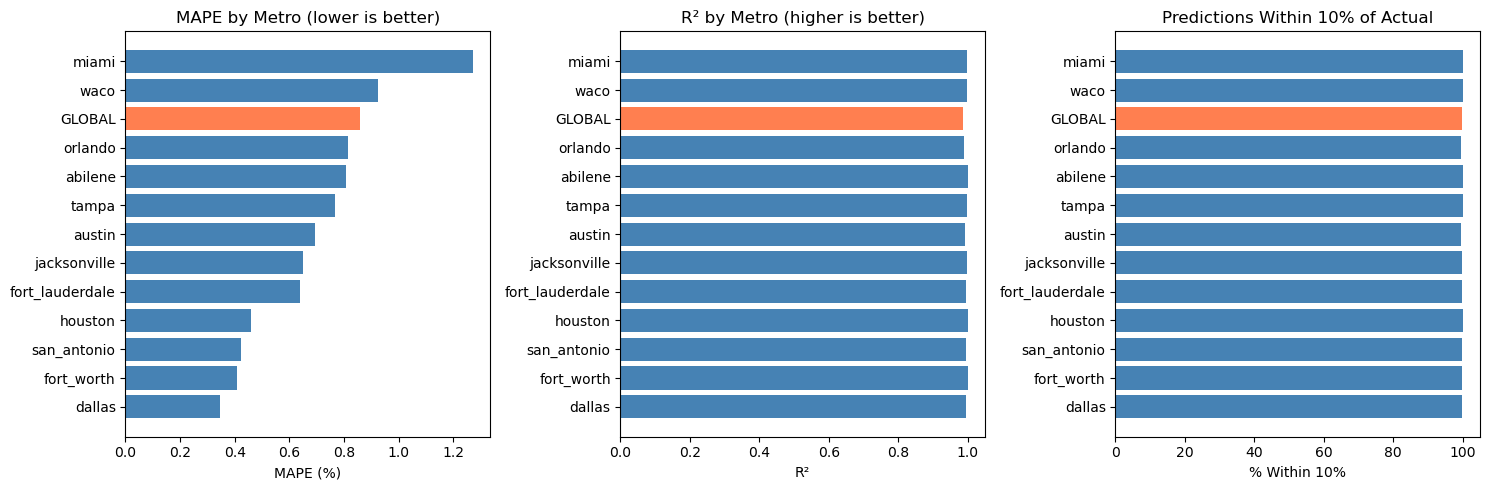

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAPE comparison
ax = axes[0]
colors = ['coral' if m == 'GLOBAL' else 'steelblue' for m in df_comparison['metro']]
ax.barh(df_comparison['metro'], df_comparison['mape'], color=colors)
ax.set_xlabel('MAPE (%)')
ax.set_title('MAPE by Metro (lower is better)')

# R² comparison
ax = axes[1]
ax.barh(df_comparison['metro'], df_comparison['r2'], color=colors)
ax.set_xlabel('R²')
ax.set_title('R² by Metro (higher is better)')
ax.axvline(x=0, color='gray', linestyle='-', alpha=0.5)

# Within 10% comparison
ax = axes[2]
ax.barh(df_comparison['metro'], df_comparison['within_10pct'], color=colors)
ax.set_xlabel('% Within 10%')
ax.set_title('Predictions Within 10% of Actual')

plt.tight_layout()
plt.show()

## 6. Analyze Prediction Errors

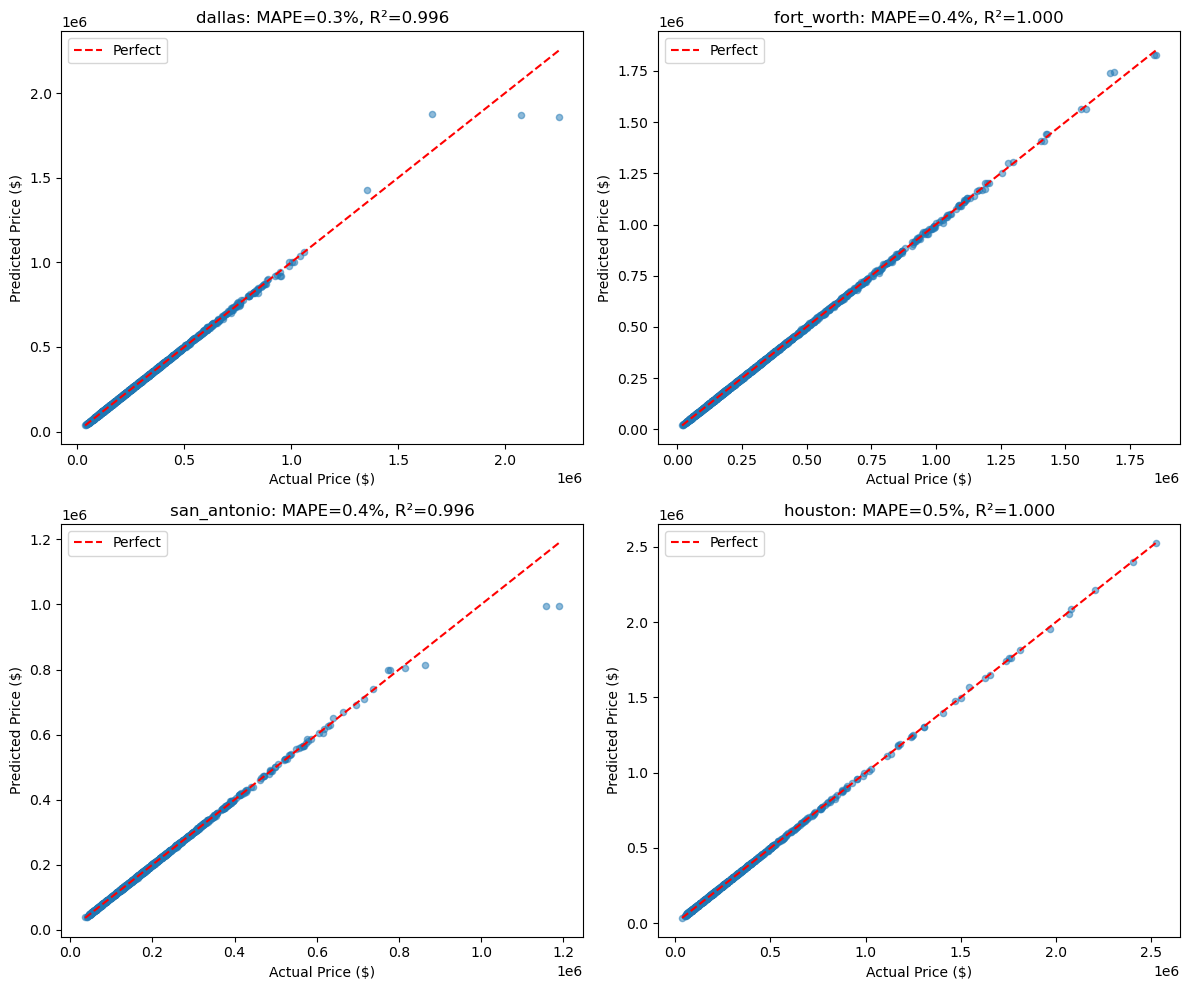

In [12]:
# Actual vs Predicted scatter plots for top metros
top_metros = df_comparison[df_comparison['metro'] != 'GLOBAL'].nsmallest(4, 'mape')['metro'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, metro in enumerate(top_metros):
    result = metro_results[metro]
    ax = axes[i]
    
    ax.scatter(result['y_test'], result['y_pred'], alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(result['y_test'].min(), result['y_pred'].min())
    max_val = max(result['y_test'].max(), result['y_pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
    
    ax.set_xlabel('Actual Price ($)')
    ax.set_ylabel('Predicted Price ($)')
    ax.set_title(f"{metro}: MAPE={result['metrics']['mape']:.1f}%, R²={result['metrics']['r2']:.3f}")
    ax.legend()

plt.tight_layout()
plt.show()

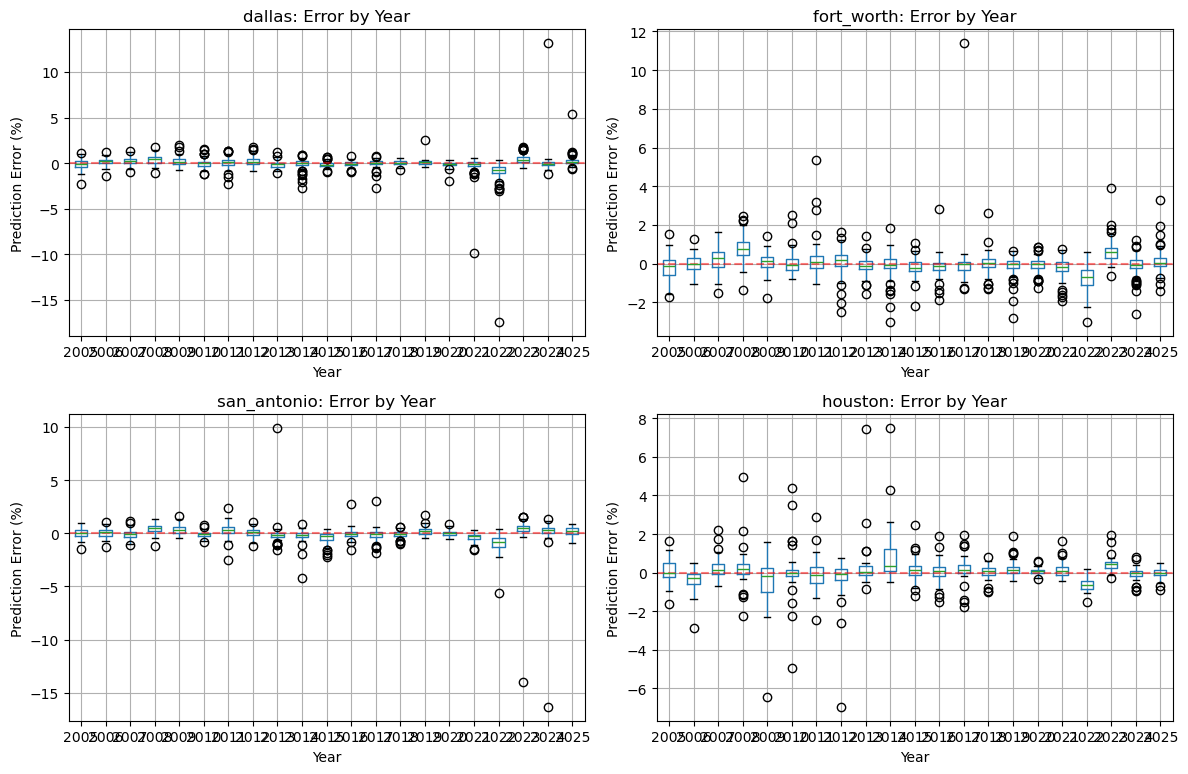

In [13]:
# Error distribution by year (to verify 2025 predictions are accurate)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, metro in enumerate(top_metros):
    result = metro_results[metro]
    ax = axes[i // 2, i % 2]
    
    errors = (result['y_pred'] - result['y_test']) / result['y_test'] * 100
    years = result['test_years']
    
    # Group by year
    df_err = pd.DataFrame({'year': years, 'error_pct': errors})
    df_err.boxplot(column='error_pct', by='year', ax=ax)
    
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('Year')
    ax.set_ylabel('Prediction Error (%)')
    ax.set_title(f'{metro}: Error by Year')

plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.show()

## 7. Save Models

In [14]:
# Create artifacts directory
artifacts_dir = Path('../ml/artifacts/v3')
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Save per-metro models
print("Saving per-metro models...")

for metro, result in metro_results.items():
    metro_dir = artifacts_dir / 'per_metro' / metro
    metro_dir.mkdir(parents=True, exist_ok=True)
    
    # Save model
    joblib.dump(result['model'], metro_dir / 'model.joblib')
    
    # Save preprocessors
    joblib.dump(result['imputer'], metro_dir / 'imputer.joblib')
    if result['scaler'] is not None:
        joblib.dump(result['scaler'], metro_dir / 'scaler.joblib')
    
    # Save feature names
    with open(metro_dir / 'feature_names.json', 'w') as f:
        json.dump(result['feature_cols'], f, indent=2)
    
    # Save metadata
    metadata = {
        'metro': metro,
        'model_type': result['model_name'],
        'uses_scaler': result['uses_scaler'],
        'n_train': result['n_train'],
        'n_test': result['n_test'],
        'n_features': len(result['feature_cols']),
        'metrics': {k: float(v) for k, v in result['metrics'].items()},
        'metrics_2025': {k: float(v) for k, v in result['metrics_2025'].items()} if result['metrics_2025'] else {},
        'created_at': datetime.now().isoformat()
    }
    
    with open(metro_dir / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"  Saved {metro}")

Saving per-metro models...
  Saved abilene
  Saved austin
  Saved dallas
  Saved fort_lauderdale
  Saved fort_worth
  Saved houston
  Saved jacksonville
  Saved miami
  Saved orlando
  Saved san_antonio
  Saved tampa
  Saved waco


In [15]:
# Save global model
print("\nSaving global model...")

global_dir = artifacts_dir / 'global'
global_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(global_model, global_dir / 'model.joblib')
joblib.dump(global_imputer, global_dir / 'imputer.joblib')
joblib.dump(metro_encoder, global_dir / 'metro_encoder.joblib')

with open(global_dir / 'feature_names.json', 'w') as f:
    json.dump(all_feature_names, f, indent=2)

global_metadata = {
    'model_type': 'global',
    'model_class': 'XGBRegressor' if HAS_XGBOOST else 'RandomForestRegressor',
    'n_train': len(train_df),
    'n_test': len(test_df),
    'n_features': len(all_feature_names),
    'metrics': {k: float(v) for k, v in global_metrics.items()},
    'metrics_2025': {k: float(v) for k, v in global_metrics_2025.items()},
    'created_at': datetime.now().isoformat()
}

with open(global_dir / 'metadata.json', 'w') as f:
    json.dump(global_metadata, f, indent=2)

print(f"  Saved global model")


Saving global model...
  Saved global model


In [16]:
# Save comparison results
df_comparison.to_csv(artifacts_dir / 'model_comparison.csv', index=False)
print(f"\nSaved comparison to {artifacts_dir / 'model_comparison.csv'}")


Saved comparison to ../ml/artifacts/v3/model_comparison.csv


## 8. Summary

In [17]:
print("="*60)
print("TRAINING SUMMARY")
print("="*60)

print(f"\nDataset:")
print(f"  Train examples: {len(train_df):,}")
print(f"  Test examples: {len(test_df):,}")
print(f"  Features: {len(feature_cols)}")

print(f"\nModels trained:")
print(f"  Per-metro models: {len(metro_results)}")
print(f"  Global fallback: 1")

print(f"\nOverall test performance:")
avg_mape = np.mean([r['metrics']['mape'] for r in metro_results.values()])
avg_r2 = np.mean([r['metrics']['r2'] for r in metro_results.values()])
print(f"  Per-metro average MAPE: {avg_mape:.2f}%")
print(f"  Per-metro average R²: {avg_r2:.4f}")
print(f"  Global MAPE: {global_metrics['mape']:.2f}%")
print(f"  Global R²: {global_metrics['r2']:.4f}")

print(f"\n2025 performance (most recent data):")
metros_with_2025 = [m for m, r in metro_results.items() if r['metrics_2025']]
if metros_with_2025:
    avg_mape_2025 = np.mean([metro_results[m]['metrics_2025']['2025_mape'] for m in metros_with_2025])
    print(f"  Per-metro average MAPE (2025): {avg_mape_2025:.2f}%")
print(f"  Global MAPE (2025): {global_metrics_2025.get('2025_mape', 'N/A')}")

print(f"\nArtifacts saved to: {artifacts_dir}")
print(f"\nNext step: Update app.py to use these models for predictions")

TRAINING SUMMARY

Dataset:
  Train examples: 40,024
  Test examples: 10,007
  Features: 16

Models trained:
  Per-metro models: 12
  Global fallback: 1

Overall test performance:
  Per-metro average MAPE: 0.68%
  Per-metro average R²: 0.9972
  Global MAPE: 0.86%
  Global R²: 0.9856

2025 performance (most recent data):
  Per-metro average MAPE (2025): 0.57%
  Global MAPE (2025): 0.8795665904817362

Artifacts saved to: ../ml/artifacts/v3

Next step: Update app.py to use these models for predictions
